Philippe Joly
MAIS 202

This is an implementation of Support Vector Regression (SVR) on Electrical Power Output based on the Weather in Quebec

In [1]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import pickle
import os
from dotenv import load_dotenv
load_dotenv()

True

# Data

In [2]:
data = pd.read_csv(os.getenv("DATA"))
data['Date/Time (UTC)'] = pd.to_datetime(data['Date/Time (UTC)'])
data.dropna(inplace=True)
data.drop(columns=['Date/Time (UTC)','Year'], inplace=True)

X_tot = data.drop(columns=["Average Power Output (MW)"]).values
y_tot = data["Average Power Output (MW)"].values

X, X_test, y, y_test = train_test_split(X_tot, y_tot, test_size=0.1, random_state=45)

In [44]:
print(f'Training set size: {X.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Number of Features: {X.shape[1]}')
print(data.drop(columns=["Average Power Output (MW)"]).keys().values)

Training set size: 31514
Test set size: 3502
Number of Features: 6
['Temp (°C)' 'Month' 'Day' 'Hour' 'Day of Week' 'Population']


In [3]:
y = y.reshape(len(y), 1)
# y_test = y_test.reshape(len(y_test), 1)

x_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)

# with open('Xscaler.pkl','wb') as f:
#     pickle.dump(x_scaler, f)
# with open('yscaler.pkl','wb') as f:
#     pickle.dump(y_scaler, f)

X = x_scaler.transform(X)
y = y_scaler.transform(y)

X_test = x_scaler.transform(X_test)
# y_test = y_scaler.transform(y_test)

y = y.reshape(y.shape[0])
# y_test = y_test.reshape(y_test.shape[0])

# Hyper-Parameter Tuning

In [5]:
svr = SVR()

In [6]:
opt_params=[{
    'C': np.logspace(-4,4,10),
    'gamma': np.logspace(-6,1,10),
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['rbf'],
    'max_iter':[2000]
}]

In [ ]:
clf = BayesSearchCV(svr, search_spaces=opt_params, cv=3, verbose=False, n_jobs=-1, n_iter=200)
best_clf = clf.fit(X,y)

In [25]:
results = pd.DataFrame(best_clf.cv_results_).sort_values(by="rank_test_score", ascending=True)

In [26]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
183,3.250043,0.025728,4.332995,0.027071,2.782559,0.01,1.668101,rbf,2000,"{'C': 2.782559402207126, 'epsilon': 0.01, 'gam...",0.98184,0.981411,0.98131,0.98152,0.00023,1
180,3.396229,0.063735,4.034710,0.058293,2.782559,0.01,1.668101,rbf,2000,"{'C': 2.782559402207126, 'epsilon': 0.01, 'gam...",0.98184,0.981411,0.98131,0.98152,0.00023,1
181,3.159868,0.029137,3.495040,0.062871,2.782559,0.01,1.668101,rbf,2000,"{'C': 2.782559402207126, 'epsilon': 0.01, 'gam...",0.98184,0.981411,0.98131,0.98152,0.00023,1
147,3.211711,0.040855,3.784475,0.074041,2.782559,0.01,1.668101,rbf,2000,"{'C': 2.782559402207126, 'epsilon': 0.01, 'gam...",0.98184,0.981411,0.98131,0.98152,0.00023,1
143,3.413598,0.053275,3.522860,0.025178,2.782559,0.01,1.668101,rbf,2000,"{'C': 2.782559402207126, 'epsilon': 0.01, 'gam...",0.98184,0.981411,0.98131,0.98152,0.00023,1


In [10]:
best_clf.best_score_

0.9815202764457135

In [55]:
best_model = best_clf.best_estimator_

y_pred = best_model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(len(y_test), 1)).reshape(y_pred.shape[0])

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

MSE: 503623.5687257564
R2: 0.9815888556826949
MAE: 568.1827592223525


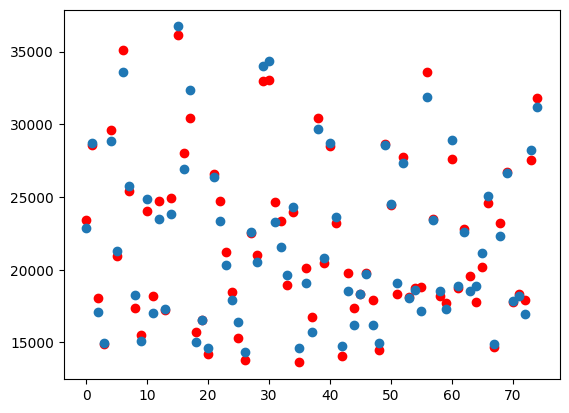

In [71]:

s=2500
l =75
ind = np.zeros(l)
for i in range(l):
    ind[i] = i
plt.scatter(ind, y_pred[s:s+l],color="red")
plt.scatter(ind, y_test[s:s+l])

In [72]:
f = "../trainedModels/svr_bayes_rbf"
pickle.dump(best_model, open(f, "wb"))